# $\ell_1$ periodogram - tutorial I - how to use it? 

The $\ell_1$ periodogram (Hara, Boué, Laskar & Correia 2017, MNRAS, 464, 1, p.1220-1246) is a data analysis tool aiming at finding periodicities in time-series. It is in particular designed to search for exoplanets in radial velocity data. In this notebook, a few usage examples are given. 

The $\ell_1$ periodogram can be used similarly to a Lomb-Scargle periodogram or its variants (e. g. Baluev 2008), but relies on a different principle. In both Lomb-Scargle-type and $\ell_1$ periodograms, one defines a frequency grid. In the first case, one fits a sinusoidal function at each frequency in the grid. In the $\ell_1$ periodogram, one searches directly for a representation of the input signal as a sum of sinusoids whose frequencies are in the input frequency grid. In a sense, all the frequencies of the signal are searched simultaneously. 

To be able to solve this seemingly ill-posed problem, we assume that the number of frequency in the signal is much smaller than the number of observations. In the context of exoplanets, is is reasonable to assume that there are most $\approx$ 15 distinct periodicities in the radial velocities, while there are typically $\geqslant$ 50-70 data points. We can then rely on the so-called "sparse recovery" tools, which are designed to find a representation of an input signal as a linear combination of a few entries of a given "dictionary" (here sine functions). The $\ell_1$ periodogram relies more precisely on the basis pursuit problem (Chen & Donoho 1998) and the group-LASSO (Yuan & Lin 2006).

The analysis of radial velocities can be difficult due to the presence of complicated noises and the fact that the data comes from different instruments. The $\ell_1$ periodogram can handle different instruments, correlated noise models, trends and linear stellar activity models.

We will cover basic uses of the $\ell_1$ periodogram and more advanced ones. We always follow three steps:
1. Load the data in the class l1p_class
2. Define the frequency grid, noise model, signal model
3. Launch the computation of the l1 periodogram

We begin with a simple example, and highlight the key parameters of the analysis. 
We always assume that the time is given in days and the radial velocity in m/s


In [1]:
#First, a few imports
import numpy as np
import matplotlib.pyplot as plt

from l1periodogram import l1periodogram_v1, covariance_matrices, combine_timeseries, filter_poly

filepath = 'Data/'


To use gglasso, run the command python -m numpy.f2py -c gglasso.f90 -m gglasso_wrapper in the directory l1periodogram_codes, then restart the kernel.


The first data set we analyse is 74 HARPS measurements of HD 69830, that permitted the detection of three Neptunes (Lovis et al. 2006, A&A)

In [2]:
dataset_names = ['HD69830_2006.dat']
dataset_path = [filepath+d for i,d in enumerate(dataset_names)]

#Load the data from the file
T,y,err,offsets,dico, dict_out, dataset_names_out = \
                        combine_timeseries.create_dataset(dataset_path,
                         bintimescale = 0.7)

------------- 

## Three step process to compute the $\ell_1$ periogogram.
### Step 1. Load the data in the class 

In [3]:
#T is the measurement times and y is the time series to analyse
c = l1periodogram_v1.l1p_class(T,y)
# You now have access to the time of observations and time series c.t_init and c.y_init
# For numerical stability, we will now consider these same values but centeresd
# c.t = c.t_init - np.mean(c.t_init)
# c.y = c.y_init - np.mean(c.y_init)

# You might want to give names of the star under consideration, the datasets and the offsets (for plots)
c.starname = 'HD 69830'
c.dataset_names = dataset_names_out
c.offsets = offsets

<span style="color:#8B0000;font-size:12pt">
You might be surprised that error bars were not mentionned, it's coming now
</span>

### Step 2. Define the model

We now need to define several elements of the signal model

- The frequency grid (class attribute "omegas"): the signal will be decomposed as sinusoids on this grid 
- The noise model (class attribute "V"), in the form of the assumed covariance matrix of the noise
- The vectors assumed to be in the model, (class attribute "MH0"). There might be vectors that are known to be in the data, such as an offset, a trend, or a linear activity model, that we want to include by default in the model. 

In the following examples, we use a simple covariance model, where the covariance matrix is defined as:
<span style="font-size:12pt">
$$V_{kl} = \delta_{kl}(\sigma_k^2 + \sigma_W^2) + \sigma_R^2 \mathrm{e}^{-\frac{(t_k-t_l)^2}{2\tau^2}} $$
</span>
where $\sigma_W$ (m/s), $\sigma_R$ (m/s)and $\tau$ (d) are user defined. 

Creating dictionary
Projection matrix set, dimension of the unconstrained space (number of MH0 columns): 1
Model creation duration 0.45134735107421875 seconds


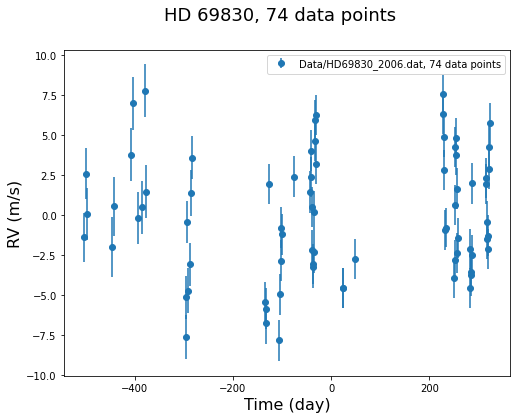

In [4]:
#We define a covariance model
sigmaW = 1. #We add in quadrature 1 m/s to the nominal HARPS errors 
sigmaR, tau = 0. ,0. #No red noise
sigma_calib = 0. #No calibration noise
V = covariance_matrices.covar_mat(T,err, sigmaW, sigmaR,sigma_calib,tau)

#To set the model use the method:
c.set_model(omegamax = 3*np.pi, #We will search frequencies up to 1.5 cycles/day = 3*np.pi rad/day
                  V = V,
                MH0 = offsets)#The only vector we assumed to be in the data by default is the offset

#Now the noise model is defined, let us plot the data
#The error bars are the square root of the diagonal of V
c.plot_input_data()

### Step 3. Run the $\ell_1$ periodogram

We have defined what is needed to compute the $\ell_1$ periodogram.

We here define: 
- The numerical method that will be used to solve the basis pursuit model (class attribute "numerical_method"). Depending on this, the dictionary columns may need to be normalized or orthonormalized. By default, we use the LARS algorithm with lasso modification (Efron, Hastie, Johnstone, Tibshirani 2004, Ann. Stat.), one can also use gglasso (Yang, Y. and Zou, H.(2015)). 
- Once the $\ell_1$ periodogram is computed, we want to determine whether the peaks are significant. We here set the methods to evaluate the significance: ['faps', 'evidence_laplace'], that are false alarm probabilities and Laplace approximation of Bayesian evidences. We also define that the significance tests will be done on the max_n_significance_tests=5 highest peaks of the $\ell_1$ periodogram.


--------- l1 periodogram: start ---------
Setting minimization input
Weighting the dictionary
Weighting dictionary duration 0.06478261947631836 seconds
Dictionary columns centred
Dictionary columns normalized
Computing LARS path
Number of lasso modifications in lars:  4 in 21 iterations
LARS duration 0.24670743942260742 seconds
Smoothing lasso solution
Smoothing duration  0.010933637619018555 seconds
Find peaks duration 0.008177995681762695 seconds


/home/denis/w/l1periodogram/l1periodogram/l1periodogram_v1.py:1183: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(string_save , rasterized = True,


Plot (clean) duration  0.5479357242584229 seconds
Evaluating peaks significance
Significance evaluation 1 / 5
Significance evaluation 2 / 5
Significance evaluation 3 / 5
Significance evaluation 4 / 5
Significance evaluation 5 / 5
Significance evaluation duration 0.5518183708190918 seconds


/home/denis/w/l1periodogram/l1periodogram/l1periodogram_v1.py:1023: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(string_save, format='pdf', rasterized = True)


Plot (with list) duration  0.38379955291748047 seconds
--------- l1 periodogram: end ----------
Total time:  1.9048552513122559  seconds
----------------------------------------


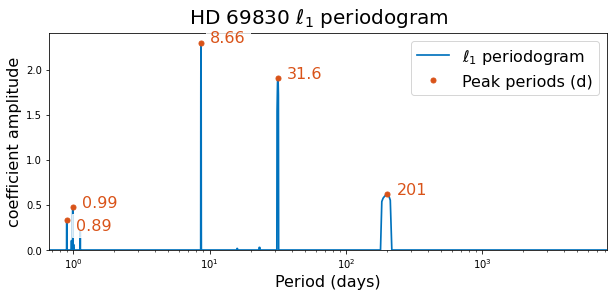

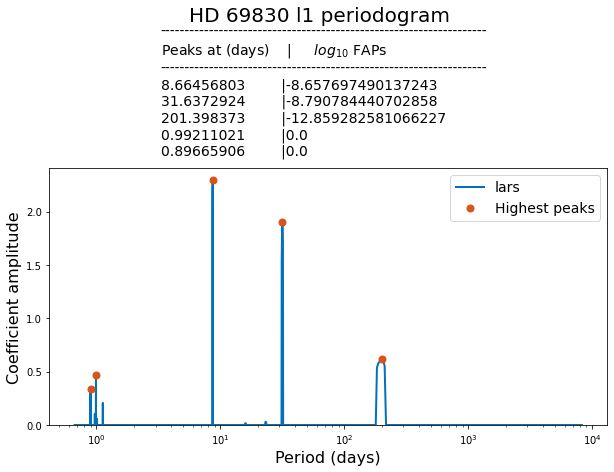

In [5]:
c.l1_perio(numerical_method='lars',
           significance_evaluation_methods = ['fap','evidence_laplace'],
           max_n_significance_tests=5,verbose=1)

------------- 

## Outputs

The two output plots show the same figure: the amplitude of the coefficients of the periodogram as a function of frequency. The upper one is intended for publications and the second is intended for analysis purposes. They can be computed after running the l1_perio method through the methods "plot_clean" and "plot_with_list". In the plot_clean method, you can specify which peaks annotations you want (see below). 

We find several peaks in the $\ell_1$ periodogram. In the second plot, they are listed by decreasing amplitude along with a significance threshold, which is computed as described in Hara, Boué, Laskar, Correia 2017. That is, we compute a sequence of false alarm probabilities of periodograms where the base models are a sequence of $n$ planets models at the $n$ tallest peaks of the $\ell_1$ periodogram. Here, we compare {signal at 8.664 d + MH0 linear model} vs {MH0 linear model}, then {signal at 8.664 d + signal at 31.637 d + MH0 linear model} vs {signal at 8.664 d + MH0 linear model} and so on. 

We can compare these models with approximate evidence calculations (laplace approximation) as described in Nelson, Ford, et al. 2018, AJ, see Appendix A.4.). We can plot the same figures with this significance metric. You can also access the frequencies and values of the peaks with the attributes "omega_peaks" and "peakvalues". The significance values are accessible as elements of the "significance" attributes, which is a Python dictionary. 

Here, the result suggests the detection of three planets at 8, 31 and 201 d, as claimed in Lovis et al. 2006. 

Peaks at  [  8.66456803  31.63729246 201.39837398   0.99211022   0.89665907
   1.1269733    0.97145098   1.00711469  23.2600939    1.00332118
  15.97163121]  days
With amplitude  [2.2945797  1.9051019  0.61734962 0.47126764 0.33455363 0.206846
 0.10416069 0.0601442  0.02920694 0.02151761 0.01726717]
With log10fap  [ -8.65769749  -8.79078444 -12.85928258   0.           0.        ]
With approx. log10 evidence   [70.37496476 30.09527973 13.83164941 -1.78981661 -2.28895512]


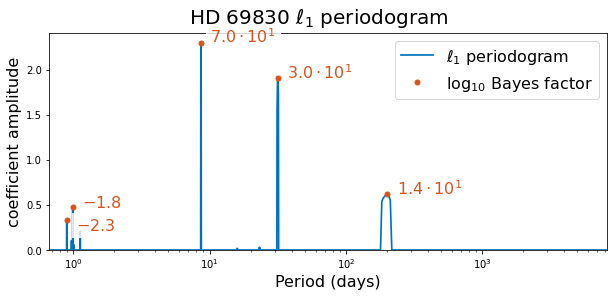

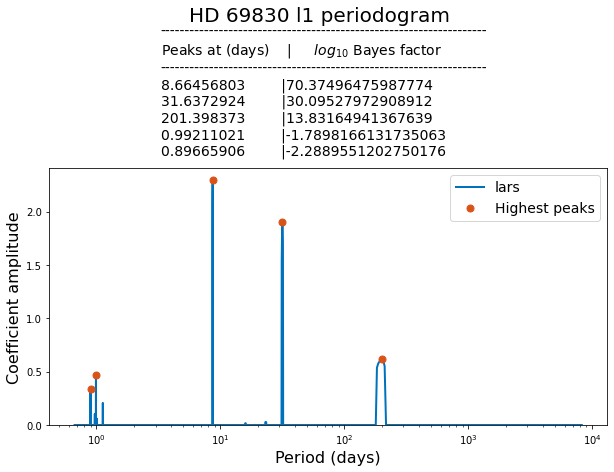

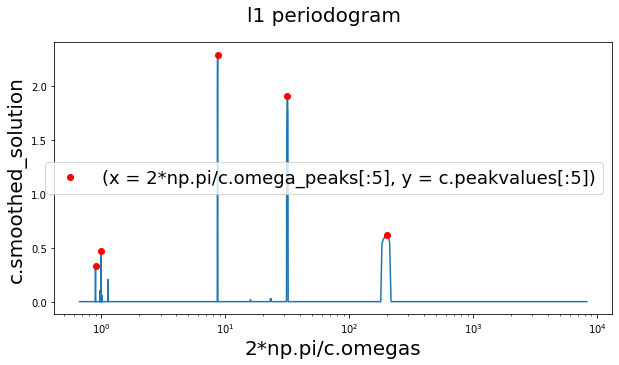

In [6]:
#We highlight the  highest peaks 
c.plot_clean(5, annotations = 'log10_bayesf_laplace', save = False)
c.plot_with_list(5, significance_values = 'log10_bayesf_laplace', save = False)
#The keyword saves determines if the plot is saved or not

print('Peaks at ', 2*np.pi/c.omega_peaks[:12], ' days')
print('With amplitude ', c.peakvalues)
print('With log10fap ', c.significance['log10faps'])
print('With approx. log10 evidence  ', c.significance['log10_bayesf_laplace'])

#The value of the l1 periodogram abscissa and ordinates respectively are c.omegas and c.smoothed_solution
plt.figure(figsize=(10,5))
plt.suptitle('l1 periodogram', fontsize=20)
plt.semilogx(2*np.pi/c.omegas, c.smoothed_solution)
plt.xlabel('2*np.pi/c.omegas', fontsize=20)
plt.ylabel('c.smoothed_solution', fontsize=20)
plt.semilogx(2*np.pi/c.omega_peaks[:5], c.peakvalues[:5],'o',color='red', label='(x = 2*np.pi/c.omega_peaks[:5], y = c.peakvalues[:5])')
plt.legend(fontsize=18)

#### Amplitudes

The amplitudes plotted ('coefficient amplitudes' or 'c.smoothed_solution' on the $y$ axes) have the dimension of meters per second. However, one must keep in mind that the $\ell_1$ penalization leads to underestimate the true value of the eccentricity.

------
## Changing the assumptions (frequency grid, noise model, solver, unpenalized vectors) 

### Checking the current dictionary values
You can check the values in current use in the dictionary with the method "show_dict_parameters"

Dictionary parameters
Max frequency in the frequency grid, omegamax: 9.42477796076938 rad/day, corresponding to a period  0.6666666666666666  d
Oversampling of the frequency grid, oversampling: 10
Number of phases per frequency, Nphi: 8
Dictionary set for the numerical_method matrix: lars
Unpenalized vectors, MH0: 
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


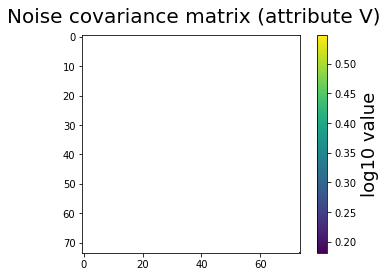

In [7]:
c.show_dict_parameters()

### Changing the frequency grid

The published planets are not the only peaks appearing in the $\ell_1$ periodogram, and we find traces of their aliases. Once it has been checked that there are no hints of planets with a period < 1 day, the figure can be re-computed on a grid exculding the aliases. This is easily done as:

Creating dictionary
Max frequency updated
Model creation duration 0.0007421970367431641 seconds


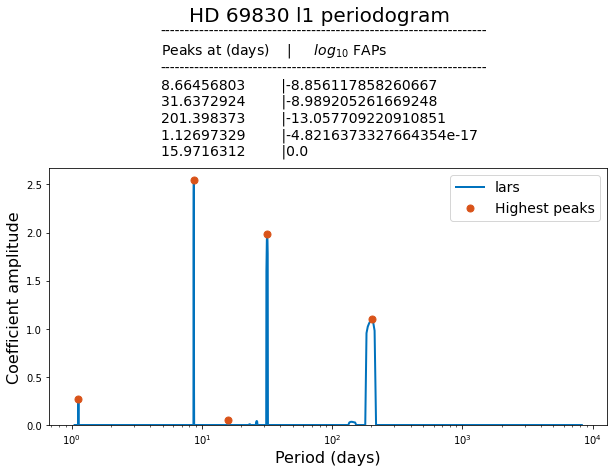

In [8]:
#Redefine the dictionary 
c.update_model(omegamax = 1.9*np.pi) 
#Recompute the l1 periodogram
c.l1_perio(verbose=0,max_n_significance_tests = 5, plot_output = False) # We do not plot both outputs
c.plot_with_list(5, significance_values = 'log10faps', save = False)

### Changing the noise model

More generally, one can re-define the dictionary using the update_dictionary routine, by enteernig the values to update as key words. For instance, let us suppose we want to compute the l1 periodogram with a red noise model. We consider a Gaussian, stationary noise with a white component of amplitude $\sigma_W$, added in quadrature to the nominal uncertainties, and a red component amplitude $\sigma_R$ and time-scale $\tau$ 

Creating dictionary
Model creation duration 0.001287698745727539 seconds
There are only 3 peaks


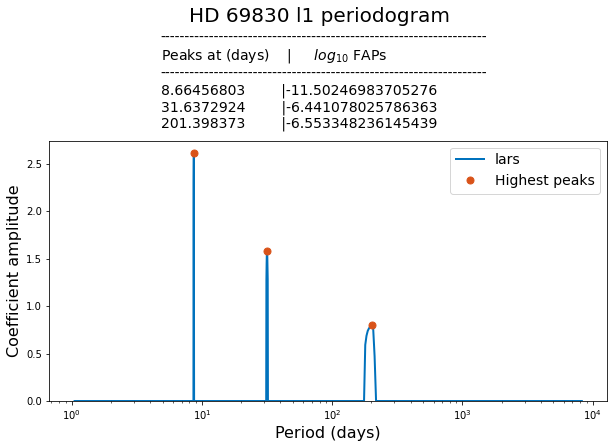

In [9]:
# We take the following values 
sigmaW = 1.
sigma_calib = 0.
sigmaR = 1.
tau = 3.

Vred = covariance_matrices.covar_mat(T,err, sigmaW, sigmaR,
              sigma_calib,tau, tol = 1e-8,kernel='gaussian')

#Let us redefine the dictionary 
c.update_model(V=Vred) 
#Recompute the l1 periodogram  -  We here set verbose to 0
c.l1_perio(verbose=0,max_n_significance_tests = 5, plot_output=False) 
c.plot_with_list(5, significance_values = 'log10faps', save = False)

It apperas that the amplitude of the low frequency and its significance has decreased. This is understandable as red noise models tend to act as high-pass filters. This behaviour is explained in greater detail in Delisle, Hara, Ségransan 2020, A&A. 

### Changing unpenalized vectors

It has been said above that some vectors can be added to the model without being put in competition with the other vectors in the dictionary. For instance, we might assume that, besides the offset a trend is present. We then redefine the attribute MH0 as follows. 

Creating dictionary
Projection matrix set, dimension of the unconstrained space (number of MH0 columns): 2
Model creation duration 0.1979990005493164 seconds
There are only 4 peaks


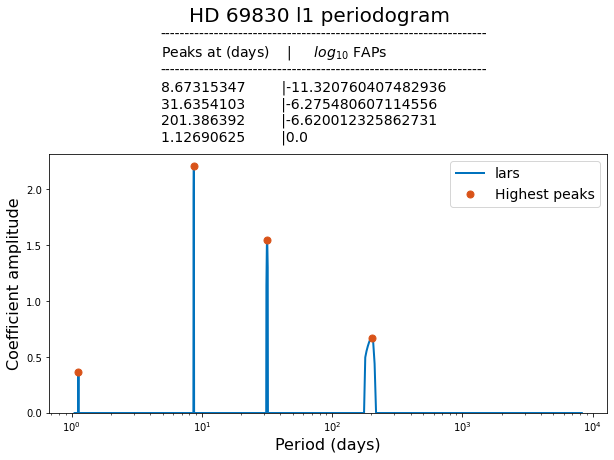

In [10]:
#Redefine unpenalized vectors
M1 = np.ones((c.Nt, 2))
M1[:,1] = c.t
c.update_model(MH0 = M1, numerical_method = 'lars', Nphi = 4, omegamax= 1.9*np.pi)

#Recompute the l1 periodogram
c.l1_perio(verbose=0,max_n_significance_tests = 5, plot_output=False) 
c.plot_with_list(5, significance_values = 'log10faps', save = False)

Note that this does not change drastically the periodogram, and decreases the statistica significance of the 201 d signal. Just like a correlated noise model, the degeneracy with long periods is expected to reduce the significance of the detections. 

##### Adding unpenalized periods

one important feature of the $\ell_1$ periodogram is that it can struggle to find the correct signals when the data contain periodic signals with very different amplitudes. This can happen in particular in systems with giant planets and terrestrial ones. This stems from the fact that the $\ell_1$ penalization leads to underestimate the amplitude of the strong signals. 

To circumvent this issue, once a very strong signal is spotted it might be advisable to remove it from the dictionary, and adding it to the MH0 matrix of unpenalized vectors. There is a specific method for this called "unpenalize_periods". One selects a base model, and adds a list of periods to remove from the minimization. In our example, we could unpenalize 8.6731 d. 

Creating dictionary
Projection matrix set, dimension of the unconstrained space (number of MH0 columns): 3
Model creation duration 0.0004241466522216797 seconds
There are only 2 peaks


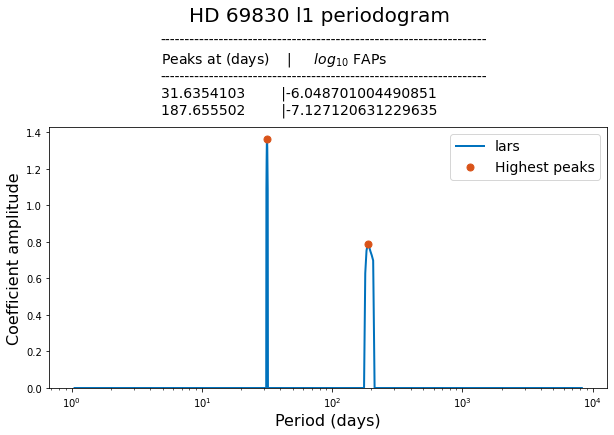

In [11]:
c.unpenalize_periods([8.67315347],offsets, numerical_method='lars')
#We recompute the l1 periodogram
c.l1_perio(max_n_significance_tests = 5, plot_output=False, verbose=0)
c.plot_with_list(5, significance_values = 'log10faps', save = False)

We now only find the two signals corresponding to the remaining planets in the system. Note that the longest period has sliglthly changed, but the peak covers the same range as before. The difference in period estimates stems from the fact that the frequency grid is discretized. 

### Changing the solver

One could also want to change the numerical solver of the l1 periodogram to gglasso. We use the LARS algorithm by default, as our implementation of gglasso is still being improved. 

<span style="color:#8B0000;font-size:12pt">
To use this feature, proceed as follows. If you haven't already run the command line "python -m numpy.f2py -c gglasso.f90 -m gglasso_wrapper" in the l1_periodogram directory, then do so or run the following cell, then restart the kernel
</span>

In [12]:
#!(cd l1periodogram_codes && python -m numpy.f2py -c gglasso.f90 -m gglasso_wrapper)

In [13]:
# Running gglasso
#c.l1_perio(numerical_method='gglasso', plot_output=False)
#c.plot_with_list(5, significance_values = 'log10faps', save = False)

____________
_____________

# Other examples
----- 
-----

## HD 10180 
We re-analyse the data of Lovis et al. 2011, A&A

Creating dictionary
Projection matrix set, dimension of the unconstrained space (number of MH0 columns): 1
Model creation duration 1.5417134761810303 seconds
--------- l1 periodogram: start ---------
Setting minimization input
Weighting the dictionary
Weighting dictionary duration 0.5826020240783691 seconds
Dictionary columns centred
Dictionary columns normalized
Computing LARS path
Number of lasso modifications in lars:  20 in 120 iterations
LARS duration 7.235758066177368 seconds
Smoothing lasso solution
Smoothing duration  0.13993215560913086 seconds
Find peaks duration 0.026955127716064453 seconds


/home/denis/w/l1periodogram/l1periodogram/l1periodogram_v1.py:1183: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(string_save , rasterized = True,


Plot (clean) duration  0.4104125499725342 seconds
Evaluating peaks significance
Significance evaluation 1 / 8
Significance evaluation 2 / 8
Significance evaluation 3 / 8
Significance evaluation 4 / 8
Significance evaluation 5 / 8
Significance evaluation 6 / 8
Significance evaluation 7 / 8
Significance evaluation 8 / 8
Significance evaluation duration 2.2282650470733643 seconds


/home/denis/w/l1periodogram/l1periodogram/l1periodogram_v1.py:1023: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(string_save, format='pdf', rasterized = True)


Plot (with list) duration  0.5091845989227295 seconds
--------- l1 periodogram: end ----------
Total time:  11.660420894622803  seconds
----------------------------------------


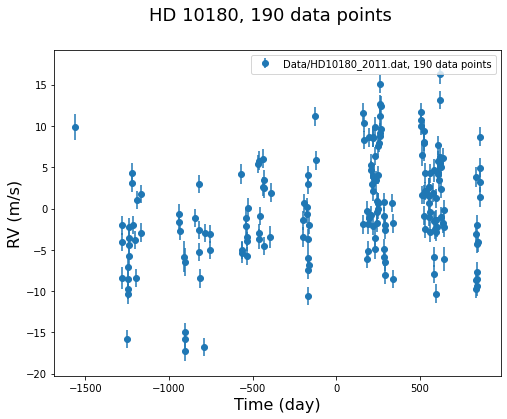

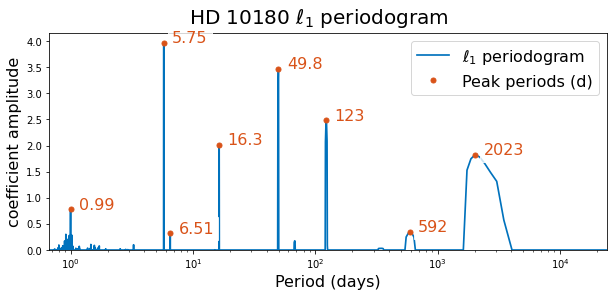

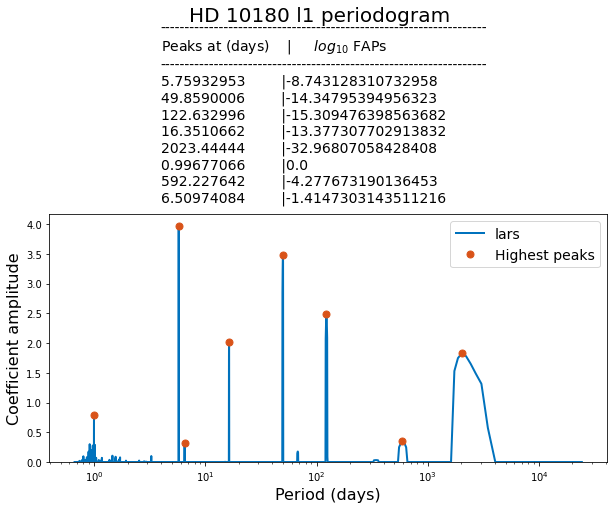

In [14]:
dataset_names = ['HD10180_2011.dat']
dataset_path = [filepath+d for i,d in enumerate(dataset_names)]

#Load the data from the file
T,y,err,offsets,dico, dict_out, dataset_names_out = \
                        combine_timeseries.create_dataset(dataset_path,
                         bintimescale = 0.7)
    
    
# --- Step 1: define the class --- #
d = l1periodogram_v1.l1p_class(T,y)
d.starname = 'HD 10180'
d.dataset_names = dataset_names_out
d.offsets = offsets

# --- Step 2: define the dictionary --- #
sigmaW = 1. #We add in quadrature 1 m/s to the nominal HARPS errors 
sigmaR, tau = 0. ,0. #No red noise
sigma_calib = 0. #No calibration noise
V = covariance_matrices.covar_mat(T,err, sigmaW, sigmaR,sigma_calib,tau)
d.set_model(omegamax = 3*np.pi, #We will search frequencies up to 1.5 cycles/day = 3*np.pi rad/day
                  V = V,
                MH0 = offsets)#The only vector we assumed to be in the data by default is the offset
d.plot_input_data()

# --- Step 3: compute the l1 periodogram --- #
d.l1_perio(verbose=1,max_n_significance_tests=8)


0.996 is an alias of a the long period, let us shrink the frequency grid to avoid aliasing

Note also that there is a forest of peaks close to one day. The method is supposed to give a sparse output (most of the frequencies should have zero amplitude if our model is correct). This might mean that the noise level is underestimated. The noise model can in fact be estimated automatically (see Hara, Bouchy, Stalport, Boisse et al. 2020, A&A), but this feature is not available yet in this code distribution.

Creating dictionary
Model creation duration 0.9821877479553223 seconds


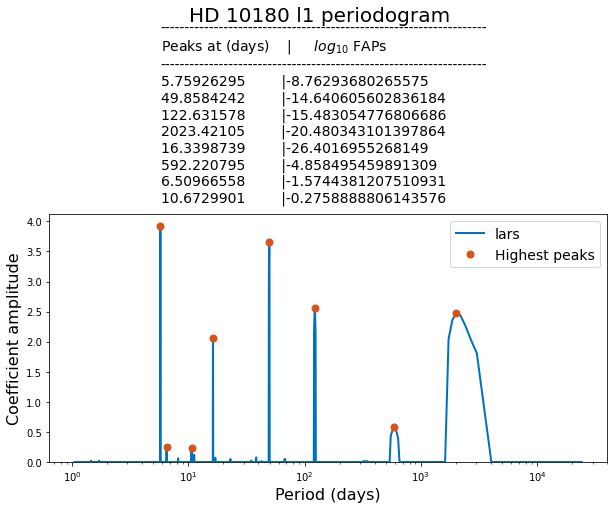

In [15]:
sigmaW = 1.5 #We add in quadrature 2 m/s to the nominal HARPS errors 
sigmaR, tau = 0. ,0. #No red noise
sigma_calib = 0. #No calibration noise
V = covariance_matrices.covar_mat(T,err, sigmaW, sigmaR,sigma_calib,tau)

d.update_model(omegamax=1.9*np.pi, V=V) 
d.l1_perio(verbose=0,max_n_significance_tests=8, plot_output=False)
d.plot_with_list(8, significance_values = 'log10faps', save = False)

-----
## GJ 876

For this system, there are data from different intruments. In that case, we simply add the offsets to the matrix of unpenalized vectors, MH0.

<span style="color:#8B0000;font-size:12pt">
Here there are many data points spanning on several years, the frequency grid is therefore tight and you might expect a running time of approximately 2 min. 
</span>


Creating dictionary
Projection matrix set, dimension of the unconstrained space (number of MH0 columns): 3
Model creation duration 5.6878252029418945 seconds
--------- l1 periodogram: start ---------
Setting minimization input
Weighting the dictionary
Weighting dictionary duration 2.3237533569335938 seconds
Dictionary columns centred
Dictionary columns normalized
Computing LARS path
Number of lasso modifications in lars:  35 in 193 iterations
LARS duration 79.04034280776978 seconds
Smoothing lasso solution
Smoothing duration  0.4385039806365967 seconds
Find peaks duration 0.09179019927978516 seconds


/home/denis/w/l1periodogram/l1periodogram/l1periodogram_v1.py:1183: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(string_save , rasterized = True,


Plot (clean) duration  1.0036773681640625 seconds
Evaluating peaks significance
Significance evaluation 1 / 8
Significance evaluation 2 / 8
Significance evaluation 3 / 8
Significance evaluation 4 / 8
Significance evaluation 5 / 8
Significance evaluation 6 / 8
Significance evaluation 7 / 8
Significance evaluation 8 / 8
Significance evaluation duration 13.868085861206055 seconds


/home/denis/w/l1periodogram/l1periodogram/l1periodogram_v1.py:1023: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(string_save, format='pdf', rasterized = True)


Plot (with list) duration  0.5272195339202881 seconds
--------- l1 periodogram: end ----------
Total time:  99.4866635799408  seconds
----------------------------------------


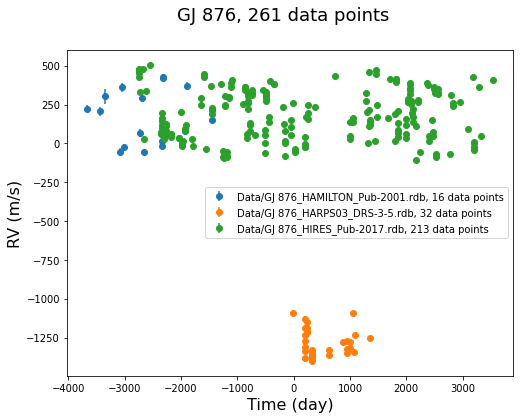

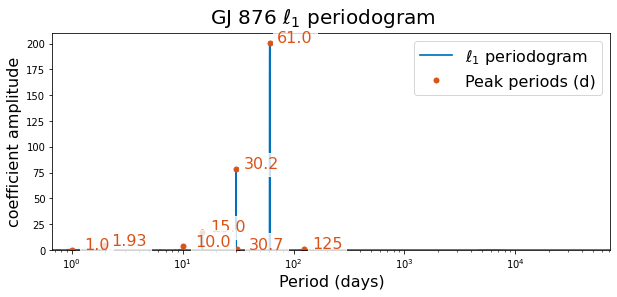

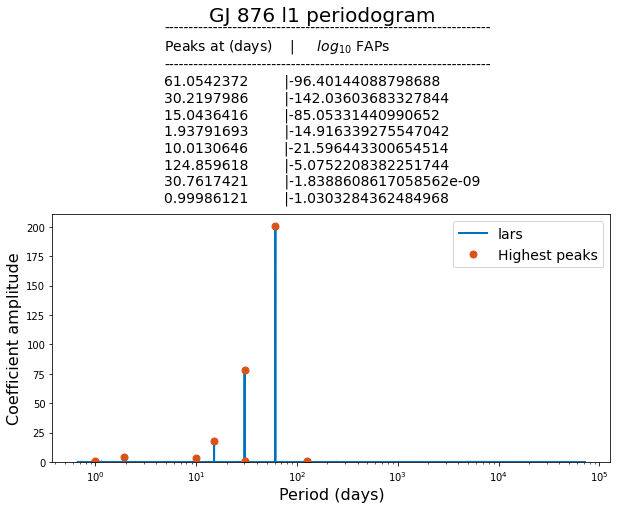

In [16]:
dataset_names = ['GJ 876_HAMILTON_Pub-2001.rdb', \
                 'GJ 876_HARPS03_DRS-3-5.rdb',\
                 'GJ 876_HIRES_Pub-2017.rdb']

dataset_path = [filepath+d for i,d in enumerate(dataset_names)]

#Load the data from the file
T,y,err,offsets,dico, dict_out, dataset_names_out = \
                        combine_timeseries.create_dataset(dataset_path,
                         bintimescale = 0.7)
        
# --- Step 1: define the class --- #
e = l1periodogram_v1.l1p_class(T,y)
e.starname = 'GJ 876'
e.dataset_names = dataset_names_out
e.offsets = offsets

# --- Step 2: define the dictionary --- #
sigmaW = 2. #We add in quadrature 2 m/s to the nominal errors 
sigmaR, tau = 0. ,0. #No red noise
sigma_calib = 0. #No calibration noise
V = covariance_matrices.covar_mat(T,err, sigmaW, sigmaR,sigma_calib,tau)
e.set_model(omegamax = 3*np.pi, #We will search frequencies up to 1.5 cycles/day = 3*np.pi rad/day
                  V = V,
                MH0 = offsets)#The only vector we assumed to be in the data by default is the offset
e.plot_input_data()

# --- Step 3: compute the l1 periodogram --- #
e.l1_perio(verbose=1,max_n_significance_tests=8)

In this system, we observe six significant signals: 61, 30, 1, 1.93, 10 and 124 d. It can be shown that 61 and 30 d correspond to two giant planets in 2:1 mean motion resonance (Correia et al. 2010, A&A), and that the 15 and 10 days signals are traces of the dynamical interactions between the Jupites (Hara, Boué, Laskar, Correia 2017, MNRAS). Indeed, when simulating only two Jupiters at the initial positions and masses given by the dynamical fit, and running the $\ell_1$ periodogram (or regular periodogram) on a simulated radial velocity time series, peaks at 155 and 10 d appear.